## Wykonywanie równoległe
- Architektura master - worker.
- master - proces, z którego sterujemy wykonaniem programu
- master zleca wykonanie danej funkcji na innym procesie i ściąga wynik

```julia
Pkg.add("Distributed")
Pkg.add("SharedArrays")
```

In [7]:
using Distributed

In [8]:
# Uruchomienie procesów workerów (zwykle podajemy tyle, ile węzłów chcemy wykorzystać)
# jesli uruchamiamy konsole julii to można też użyć opcji 
# julia -p ilosc_workerów
# do usuwania workerów służy  rmprocs() - tylko dla procesu master !
if nprocs() == 1
    addprocs(2)
end
# wszystkie procesy
nprocs() |> println
# procesy workerów
# tablica identyfikatorów
workers() |> println
# ilość
nworkers()|> println

3
[2, 3]
2


In [9]:
# każdy proces ( w tym główny) ma swój identyfikator
myid()

1

### Operacje równoległe wysokopoziomowe

In [10]:
# każda operacja I^100 wykonywana jest równolegle (map) - master nie bierze udziału w obliczeniach
# wyniki wszystkich operacji równoległych są sumowane (reduce) - wykonywana w procesie wywołującym 

@distributed (+) for i=1:1000 
        BigInt(i)^100

end

10409322085141927639670203491499689537738780837791755480023910122413796284563817273031715389609548981241768473547819207141766480065813697534743324177871972318309449519400285796191029154173386427179568557187635957090705352571527670654111047109630289487169691389452699579236618703725748994463357307313300

In [11]:
# tutaj każdy proces ma swoją kopię tablicy a, więć kod nie zadziała dobrze
# @sync - czekamy na zakończenie się wszystkich obliczeń.
# master nie bierze udziału w obliczeniach.
a = zeros(10)
@sync @distributed for i=1:10
  a[i] = i
end
a


10-element Array{Float64,1}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [12]:
# tutaj tablica jest współdzielona (SharedArray), każdy proces modyfikuje jej kawałek.
using SharedArrays
a1=SharedArray{Float64}(10)
@sync @distributed for i=1:10
  a1[i] = i
end
a1



10-element SharedArray{Float64,1}:
  1.0
  2.0
  3.0
  4.0
  5.0
  6.0
  7.0
  8.0
  9.0
 10.0

In [7]:
a2=SharedArray{Int8}(10)
@sync @distributed for i=1:10
  a2[i] = myid()
end
a2

10-element SharedArray{Int8,1}:
 2
 2
 2
 2
 2
 3
 3
 3
 3
 3

In [13]:
# pmap - działa podobnie jak @parallel for bez redukcji, ale jest wydajniejsza dla dłużej trwających operacji.

lst = collect(1:10)

pmap(x->myid(),lst)


10-element Array{Int64,1}:
 2
 3
 3
 2
 3
 3
 3
 3
 3
 3

### Zbiór Julii

  0.806994 seconds (68.22 k allocations: 3.433 MiB)


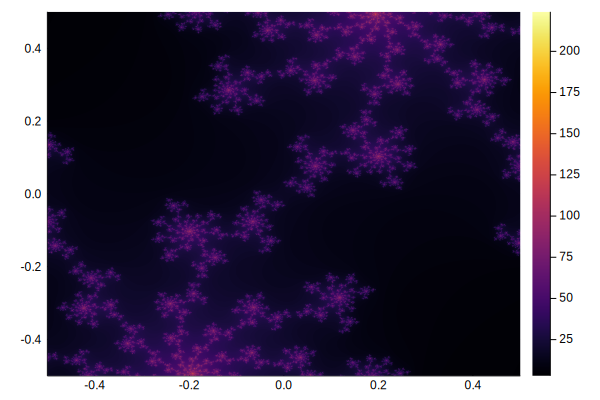

In [16]:
using Plots
# punkt o współrzędnych (x,y) należy do zbioru Julii o parametrze  c 
# jeśli dla liczby zespolonej z=x+i*y
# ciąg zₙ₊₁=zₙ²+c , nie dąży do nieskończoności

# dążenie do nieskończoności sprawdzamy ustawiająć maksymalną liczbę iteracji i sprawdzając
# czy kolejne wyrazy ciągu nie przekroczą zadanego progu (tutaj 2) w tej (bądź mniejszej)
# liczbie iteracji

# funkcja sprawdzająca, czy punkt z należy do zbioru Julii o parametrze c
function generate_julia(z; c=2, maxiter=200)
    for i=1:maxiter
        if abs(z) > 2
            return i-1
        end
        z = z^2 + c
    end
    maxiter
end

# obliczamy zbiór Julii na płaszczyźnie punktów od-do.

 function calc_julia!(julia_set, xrange, yrange; maxiter=2000, height=400, width_start=1, width_end=400)
  
  for x=width_start:width_end
        for y=1:height
            z = xrange[x] + 1im*yrange[y]
            julia_set[x, y] = generate_julia(z, c=-0.70176-0.3842im, maxiter=maxiter)
        end
  end

 end

# główna funkcja 

 function calc_julia_main(h,w)
  # ustawiamy płaszczyznę
   xmin, xmax = -0.5,0.5
   ymin, ymax = -0.5,0.5
   xrange = xmin:(xmax-xmin)/(w-1):xmax  
   yrange = ymin:(ymax-ymin)/(h-1):ymax
    
   julia_set = SharedArray{Int64,2}(w, h)
    
   # obliczamy
   @time calc_julia!(julia_set, xrange, yrange, height=h,width_start=1, width_end=w)
    
    # rysujemy
   pl=Plots.heatmap(xrange, yrange, julia_set)
   
   return pl
end


calc_julia_main(2000,2000)


Uwagi: 
- należy pamiętac o tym, że w Julii pierwsze wywołanie danej funkcji zawiera czas kompilacji, dlatego czas mierzymy dopiero od drugiego wywołania

- aby funkcja skompilowała się na każdym z workerów należy  użyć makra <a href="https://docs.julialang.org/en/v1/manual/parallel-computing/index.html#Code-Availability-and-Loading-Packages-1">
@everywhere </a>

### Ćwiczenie (na zajęciach)
- Mając dany program obliczający i rysujący zbiór Julii, napisać jego wersję równoległą w dwóch  wariantach: (1) wykorzystując parallel for, (2) wykorzystując pmap. Uzyskać przyspieszenie. Uwaga: infrastruktura udostępniona przez Juliabox nie gwarantuje dostępu do zasobów na których można uzyskać przyspieszenie. W tym celu należy użyć superkomputera Zeus.

### Zadanie

- Proszę zmierzyć przyspieszenie i efektywność na superkomputerze Zeus dla zmiennej liczby workerów (od 1 do liczby rdzeni w procesorze). Wyniki porównania proszę przedstawić na wykresie. 

